# Model 1: Linear Regression with Weather Variables

The first model is a Bayesian linear regression model that predicts the number of public transport passengers based on weather conditions and temporal features.


A Bayesian linear regression model was chosen for this analysis for several key reasons:

1. **Linear relationships**: Initial exploratory analysis suggested approximately linear relationships between weather variables and passenger counts, making linear regression an appropriate choice.

2. **Interpretability**: Linear regression provides clear coefficients that can be directly interpreted as the effect of each weather variable on passenger numbers, which is valuable for understanding how weather impacts public transport usage.

3. **Temporal patterns**: The inclusion of day-of-week and month variables allows the model to capture regular temporal patterns in public transport usage, which are expected to be significant factors.

4. **Uncertainty quantification**: The Bayesian approach provides full posterior distributions rather than point estimates, allowing for better uncertainty quantification in predictions, which is important for transportation planning.


### Model Specification

- **Target Variable**: Normalized passenger count
- **Features**:
  - Weather variables: max_temp, precipitation, pressure, humidity, cloud_cover
  - Categorical variables: is_raining, day_of_week, month

### Model Formula

The model follows the standard Bayesian linear regression form:

$$y_i \sim Normal(\mu_i, \sigma^2)$$

Where:

$$\mu_i = \alpha + \sum_{j=1}^{p} \beta_j x_{ij}$$

- $y_i$ is the normalized passenger count for observation $i$
- $\mu_i$ is the expected passenger count for observation $i$
- $\alpha$ is the intercept
- $\beta_j$ are the regression coefficients
- $x_{ij}$ are the predictor variables
- $\sigma^2$ is the variance of the error term

### Implementation

The model was implemented using Stan through the CmdStanPy interface. The implementation includes:

1. Data preparation with one-hot encoding for categorical variables
2. Prior predictive checks to ensure reasonable parameter ranges
3. MCMC sampling with 3 chains, 600 sampling iterations, and 200 warmup iterations
4. Posterior analysis of parameter distributions and model fit

### Evaluation

The model's performance was evaluated using:
- Posterior predictive checks
- Parameter convergence diagnostics
- Analysis of parameter posterior distributions
- Comparison of predicted vs. actual passenger counts


### Model 2: Hierarchical Bayesian Regression with Weather Variables

The second model is a hierarchical Bayesian regression model designed to predict the number of public transport passengers based on weather conditions and temporal features, with a specific focus on incorporating hierarchical structure for the `day_of_week` variable. This model extends the Bayesian linear regression approach of Model 1 by introducing a hierarchical structure to better capture group-specific effects and improve generalization, especially for categorical variables with multiple levels.

A hierarchical Bayesian regression model was chosen for this analysis for the following key reasons:

1. **Hierarchical relationships**: The `day_of_week` variable, with its multiple categories (e.g., Monday, Tuesday, etc.), is expected to exhibit group-specific patterns that can be modeled more effectively with a hierarchical approach, allowing for partial pooling of information across days.

2. **Improved interpretability**: By modeling `day_of_week` effects hierarchically, the model provides insights into both the overall trend across days (via `mu_dow`) and the variation between individual days (via `sigma_dow`), enhancing the understanding of temporal impacts on passenger counts.

3. **Temporal patterns**: Similar to Model 1, the inclusion of `day_of_week`, `month`, and weather variables captures regular temporal and environmental patterns, but the hierarchical structure for `day_of_week` allows for more robust estimation, especially when data for some days may be sparse.

4. **Uncertainty quantification**: The Bayesian framework, combined with hierarchical modeling, provides full posterior distributions for all parameters, including group-level effects, offering a comprehensive quantification of uncertainty, which is crucial for reliable transportation planning and decision-making.

#### Model Specification

- **Target Variable**: Normalized passenger count
- **Features**:
  - Weather variables: `max_temp`, `precipitation`, `pressure`, `humidity`, `cloud_cover`
  - Categorical variables: `is_raining`, `day_of_week`, `month`
  - Hierarchical structure applied specifically to `day_of_week` to model group-specific effects

#### Model Formula

The model follows an extended Bayesian linear regression form with a hierarchical component for `day_of_week`:

$$y_i \sim Normal(\mu_i, \sigma^2)$$

Where:

$$\mu_i = \alpha + \sum_{j=1}^{p} \beta_j x_{ij}$$

- $y_i$ is the normalized passenger count for observation $i$
- $\mu_i$ is the expected passenger count for observation $i$
- $\alpha$ is the intercept (global baseline)
- $\beta_j$ are the regression coefficients for all features, with special treatment for `day_of_week`:
  - For non-`day_of_week` features (e.g., `is_raining`, `max_temp`): $\beta_j \sim Normal(0, \sigma_{\beta})$
  - For `day_of_week` features: $\beta_j \sim Normal(\mu_{dow}, \sigma_{dow})$, where:
    - $\mu_{dow} \sim Normal(0, \sigma_{\mu_{dow}})$ is the group-level mean for `day_of_week` effects
    - $\sigma_{dow} \sim Cauchy(0, \sigma_{\sigma_{dow}})$ is the group-level standard deviation for `day_of_week` effects
- $x_{ij}$ are the predictor variables
- $\sigma^2$ is the variance of the error term, with $\sigma \sim Cauchy(0, \sigma_{\sigma})$

#### Implementation

The model was implemented using Stan through the CmdStanPy interface, with the following steps:

1. **Data preparation**: One-hot encoding for categorical variables (`is_raining`, `day_of_week`, `month`), with `dow_indices` defined to identify `day_of_week` features for hierarchical modeling.
2. **Prior predictive checks**: Performed to ensure that the chosen prior distributions generate reasonable ranges for predictions and parameters.
3. **MCMC sampling**: Conducted with 4 chains, 1000 sampling iterations, and 500 warmup iterations (adjustable based on convergence diagnostics).
4. **Posterior analysis**: Includes visualization of parameter posterior distributions, hierarchical effects, posterior predictive checks, and model fit evaluation.

#### Evaluation

The model's performance was evaluated using:
- **Posterior predictive checks**: To assess how well the model’s predictions align with observed data, focusing on the hierarchical structure’s impact.
- **Parameter convergence diagnostics**: R-hat and effective sample size (N_Eff) to ensure proper MCMC convergence.
- **Analysis of parameter posterior distributions**: Examination of `alpha`, `beta`, `mu_dow`, `sigma_dow`, and `sigma` to understand their uncertainty and fit.
- **Comparison of predicted vs. actual passenger counts**: To validate the model’s predictive accuracy, especially for `day_of_week` effects.
- **Model comparison**: Use of WAIC and LOO metrics to compare Model 2 with Model 1, assessing whether the hierarchical structure improves fit and generalization.

#### Key Differences from Model 1
- **Hierarchical structure**: Model 2 introduces a hierarchical model for `day_of_week`, where effects are drawn from a common distribution (`mu_dow`, `sigma_dow`), unlike Model 1, which treats all `day_of_week` categories as independent coefficients.
- **Flexibility**: The hierarchical approach allows for partial pooling, improving estimates for days with less data by borrowing strength from the group mean.
- **Complexity**: Model 2 is more complex due to additional parameters (`mu_dow`, `sigma_dow`), requiring careful tuning of priors and more computational resources for sampling.
- **Robustness**: Better suited for datasets with grouped data (e.g., `day_of_week`), reducing overfitting compared to the independent coefficient approach in Model 1.

This hierarchical extension makes Model 2 particularly valuable for capturing nuanced temporal patterns in passenger counts, especially when data availability varies across days of the week.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from cmdstanpy import CmdStanModel
import os
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

In [2]:
ABS_PATH = 'Bayesian-analysis-of-public-transport-passengers'

In [3]:
# Set random seed for reproducibility
np.random.seed(42)
# Load preprocessed data
train_data = pd.read_csv(os.path.join(ABS_PATH,'processed_train_data.csv'))
test_data = pd.read_csv(os.path.join(ABS_PATH,'processed_test_data.csv'))

# Check if data is empty
if len(train_data) == 0:
    raise ValueError("Train data is empty. Check preprocessing step.")
if len(test_data) == 0:
    print("Warning: Test data is empty. Predictions will be skipped.")

In [4]:
# Define features and target
categorical_cols = ['is_raining', 'day_of_week', 'month']
numerical_cols = [col for col in train_data.columns if col not in ['date', 'passenger_count', 'is_raining', 'day_of_week', 'month']]
features = numerical_cols + categorical_cols
target = 'passenger_count'

In [5]:
# Prepare training and test sets
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features] if len(test_data) > 0 else pd.DataFrame(columns=X_train.columns)
y_test = test_data[target] if len(test_data) > 0 else pd.Series()

In [6]:
# Preprocess categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop=None, sparse_output=False), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ])
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test) if len(X_test) > 0 else np.array([])

In [7]:
# Get feature names after encoding
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = list(cat_feature_names) + numerical_cols
dow_indices = [i for i, name in enumerate(feature_names) if name.startswith('day_of_week_')]

# Prior

## Prior Selection Explanation

The priors used in the model were carefully selected based on the following considerations:

- **Intercept (α)**: Normal(0, 0.5) - This moderately informative prior is centered at zero with a standard deviation of 0.5. Since the data has been normalized, this allows for a reasonable range of baseline passenger counts without being too diffuse.

- **Regression Coefficients (β)**: Normal(0, 0.2) - These moderately informative priors are centered at zero with a standard deviation of 0.2. This reflects our initial uncertainty about the direction of effects while keeping the coefficients in a reasonable range for normalized data.

- **Error Standard Deviation (σ)**: Student-t(4, 0, 1) - This weakly informative prior allows for a reasonable range of noise in the data while providing some regularization to prevent extreme values.

These priors were selected to be informative enough to provide regularization and prevent overfitting, but not so strong as to overwhelm the data. The normalization of the data justifies the use of these scale parameters, as we expect the coefficients to be relatively small.

## Prior Predictive Checks

Prior predictive checks were performed to ensure that the parameters simulated from the priors make sense and produce reasonable predictions:

1. **Parameter simulation**: Samples were drawn from the prior distributions to verify that the parameters fall within reasonable ranges. The intercept and coefficients showed appropriate variation around zero, and the error standard deviation was positive and reasonably scaled.

2. **Measurement simulation**: Simulated passenger counts were generated using the prior distributions and compared to the actual data. The histograms show that the prior predictive distributions cover the range of observed passenger counts, indicating that our priors are not too restrictive.

3. **Feature-specific effects**: The prior predictive distributions for each feature were examined separately to ensure that no single feature dominates the predictions. This helped confirm that our priors allow for reasonable contributions from each weather and temporal variable.

An alternative prior for the error standard deviation (exponential(0.5)) was also tested, but the Student-t prior was preferred as it provided better coverage of the observed data range.


In [8]:
stan_data_model_1 = {
    'N': len(X_train_transformed),
    'K': X_train_transformed.shape[1],
    'X': X_train_transformed,
}

stan_data_model_2 = {
    'N': len(X_train_transformed),
    'K': X_train_transformed.shape[1],
    'X': X_train_transformed,
    'num_dow_indices': len(dow_indices),  # Add the size of the dow_indices array
    'dow_indices': [i+1 for i, name in enumerate(feature_names) if name.startswith('day_of_week_')]  # 1-based indexing for Stan
}

In [9]:
# Compile and fit model
linear_regression = os.path.join(ABS_PATH, 'stan/linear_regression.stan')
model_1 = CmdStanModel(stan_file=linear_regression)
prior_fit_model_1 = model_1.sample(data=stan_data_model_1, chains=4, iter_sampling=1000, iter_warmup=200, seed=42)

11:43:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:43:40 - cmdstanpy - INFO - CmdStan done processing.


In [16]:
hierarchial_regression = os.path.join(ABS_PATH, 'stan/hierarchial_regresion_prior.stan')
model_2 = CmdStanModel(stan_file=hierarchial_regression)
prior_fit_model_2 = model_2.sample(data=stan_data_model_2, chains=4, iter_sampling=1000, iter_warmup=200, seed=42)

12:05:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:05:25 - cmdstanpy - INFO - CmdStan done processing.


12:05:26 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 112 divergent transitions (11.2%)
	Chain 2 had 96 divergent transitions (9.6%)
	Chain 3 had 135 divergent transitions (13.5%)
	Chain 4 had 6 divergent transitions (0.6%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


### 2. Have prior predictive checks been done for parameters? [1 pt]

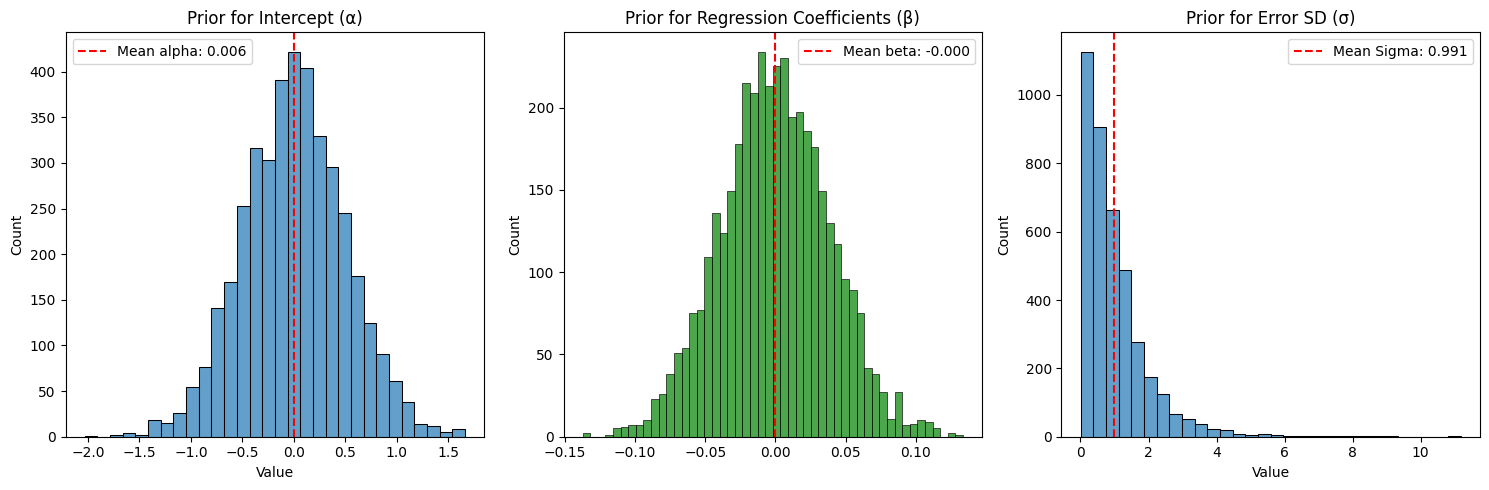

Intercept (α) prior: mean=0.006, std=0.500
Regression coefficients (β): mean=-0.000, std=0.039
Error SD (σ): mean=0.991, std=0.979


In [17]:
# Generate samples from prior distributions
alpha_samples = prior_fit_model_1.stan_variable('alpha')
beta_samples = prior_fit_model_1.stan_variable('beta')
sigma_samples = prior_fit_model_1.stan_variable('sigma')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Intercept prior
sns.histplot(alpha_samples, bins=30, alpha=0.7, ax=axes[0])
axes[0].set_title('Prior for Intercept (α)')
axes[0].axvline(np.mean(alpha_samples), color='red', linestyle='--',
               label=f'Mean alpha: {np.mean(alpha_samples):.3f}')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Count')
axes[0].legend()

# Regression coefficients prior
beta_mean = np.mean(beta_samples, axis=1)
sns.histplot(beta_mean, bins=50, alpha=0.7, color='green', ax=axes[1])
axes[1].set_title('Prior for Regression Coefficients (β)')
axes[1].axvline(np.mean(beta_mean), color='red', linestyle='--',
               label=f'Mean beta: {np.mean(beta_mean):.3f}')
axes[1].legend()

# Sigma prior
sns.histplot(sigma_samples, bins=30, alpha=0.7, ax=axes[2])
axes[2].set_title('Prior for Error SD (σ)')
axes[2].axvline(np.mean(sigma_samples), color='red', linestyle='--',
               label=f'Mean Sigma: {np.mean(sigma_samples):.3f}')
axes[2].set_xlabel('Value')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"Intercept (α) prior: mean={np.mean(alpha_samples):.3f}, std={np.std(alpha_samples):.3f}")
print(f"Regression coefficients (β): mean={np.mean(beta_mean):.3f}, std={np.std(beta_mean):.3f}")
print(f"Error SD (σ): mean={np.mean(sigma_samples):.3f}, std={np.std(sigma_samples):.3f}")


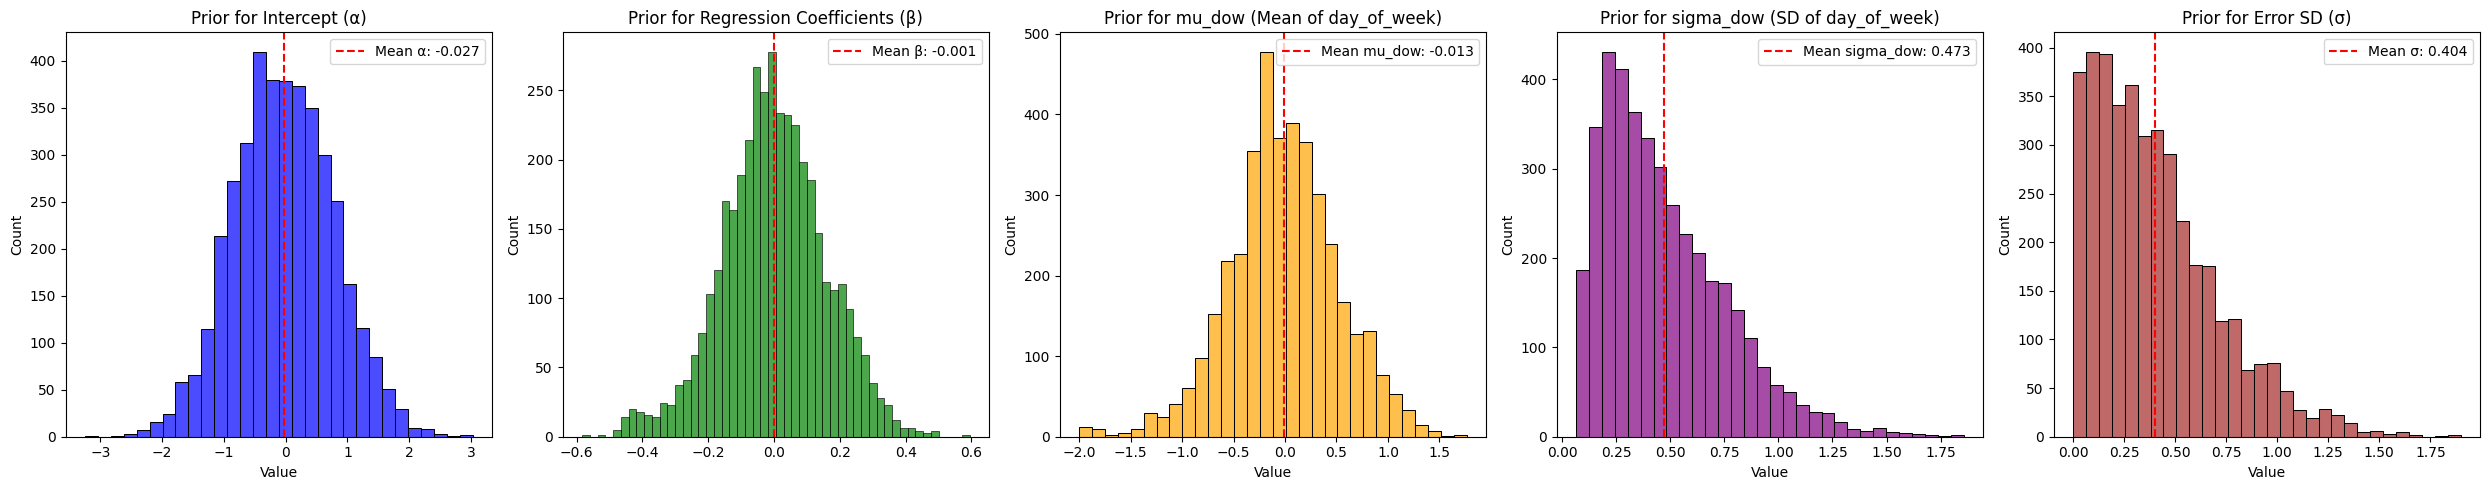

Intercept (α) prior: mean=-0.027, std=0.810
Regression coefficients (β): mean=-0.001, std=0.158
mu_dow prior: mean=-0.013, std=0.526
sigma_dow prior: mean=0.473, std=0.286
Error SD (σ): mean=0.404, std=0.305


In [18]:
# Generate samples from prior distributions for Model 2
alpha_samples = prior_fit_model_2.stan_variable('alpha')  # Intercept
beta_samples = prior_fit_model_2.stan_variable('beta')    # Feature coefficients
mu_dow_samples = prior_fit_model_2.stan_variable('mu_dow')  # Mean of day_of_week coefficients
sigma_dow_samples = prior_fit_model_2.stan_variable('sigma_dow')  # SD of day_of_week coefficients
sigma_samples = prior_fit_model_2.stan_variable('sigma')  # Noise standard deviation

# Create subplots for all priors
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

# Intercept prior (alpha)
sns.histplot(alpha_samples, bins=30, alpha=0.7, ax=axes[0], color='blue')
axes[0].set_title('Prior for Intercept (α)')
axes[0].axvline(np.mean(alpha_samples), color='red', linestyle='--',
                label=f'Mean α: {np.mean(alpha_samples):.3f}')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Count')
axes[0].legend()

# Regression coefficients prior (beta)
beta_mean = np.mean(beta_samples, axis=1)  # Average over samples for each feature
sns.histplot(beta_mean, bins=50, alpha=0.7, color='green', ax=axes[1])
axes[1].set_title('Prior for Regression Coefficients (β)')
axes[1].axvline(np.mean(beta_mean), color='red', linestyle='--',
                label=f'Mean β: {np.mean(beta_mean):.3f}')
axes[1].legend()

# Mean of day_of_week coefficients
sns.histplot(mu_dow_samples, bins=30, alpha=0.7, ax=axes[2], color='orange')
axes[2].set_title('Prior for mu_dow (Mean of day_of_week)')
axes[2].axvline(np.mean(mu_dow_samples), color='red', linestyle='--',
                label=f'Mean mu_dow: {np.mean(mu_dow_samples):.3f}')
axes[2].set_xlabel('Value')
axes[2].legend()

# Standard diviation of day_of_week coefficients
sns.histplot(sigma_dow_samples, bins=30, alpha=0.7, ax=axes[3], color='purple')
axes[3].set_title('Prior for sigma_dow (SD of day_of_week)')
axes[3].axvline(np.mean(sigma_dow_samples), color='red', linestyle='--',
                label=f'Mean sigma_dow: {np.mean(sigma_dow_samples):.3f}')
axes[3].set_xlabel('Value')
axes[3].legend()

# Sigma prior (error SD)
sns.histplot(sigma_samples, bins=30, alpha=0.7, ax=axes[4], color='brown')
axes[4].set_title('Prior for Error SD (σ)')
axes[4].axvline(np.mean(sigma_samples), color='red', linestyle='--',
                label=f'Mean σ: {np.mean(sigma_samples):.3f}')
axes[4].set_xlabel('Value')
axes[4].legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Intercept (α) prior: mean={np.mean(alpha_samples):.3f}, std={np.std(alpha_samples):.3f}")
print(f"Regression coefficients (β): mean={np.mean(beta_mean):.3f}, std={np.std(beta_mean):.3f}")
print(f"mu_dow prior: mean={np.mean(mu_dow_samples):.3f}, std={np.std(mu_dow_samples):.3f}")
print(f"sigma_dow prior: mean={np.mean(sigma_dow_samples):.3f}, std={np.std(sigma_dow_samples):.3f}")
print(f"Error SD (σ): mean={np.mean(sigma_samples):.3f}, std={np.std(sigma_samples):.3f}")

### 3. Have prior predictive checks been done for measurements? [1 pt]

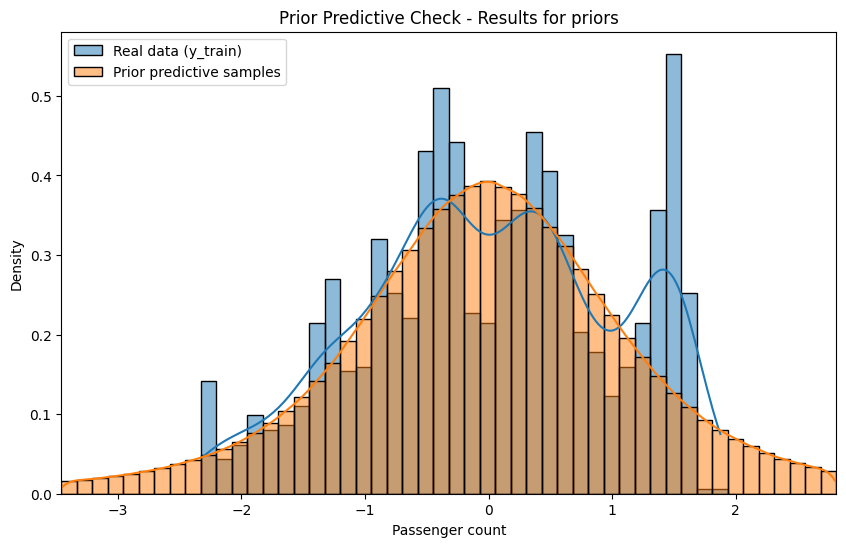

Real data range: [-2, 2]
Prior predictions range: [-37, 40]


In [19]:
y_prior_stan = prior_fit_model_1.stan_variable('y').flatten()
y_min, y_max = y_train.values.min() * 1.5, y_train.values.max() * 1.5

# Filter data to plot range
y_prior_filtered = y_prior_stan[(y_prior_stan >= y_min) & (y_prior_stan <= y_max)]

# Prior predictive check for measurements
plt.figure(figsize=(10, 6))
sns.histplot(y_train.values, bins=50, kde=True, alpha=0.5, label='Real data (y_train)',
             stat='density', binrange=(y_min, y_max))
sns.histplot(y_prior_filtered, bins=50, kde=True, alpha=0.5, label='Prior predictive samples',
             stat='density', binrange=(y_min, y_max))
plt.xlim(y_min, y_max)
plt.xlabel('Passenger count')
plt.ylabel('Density')
plt.title('Prior Predictive Check - Results for priors')
plt.legend()
plt.show()

# Data ranges and fit quality
print(f"Real data range: [{y_train.values.min():.0f}, {y_train.values.max():.0f}]")
print(f"Prior predictions range: [{y_prior_stan.min():.0f}, {y_prior_stan.max():.0f}]")


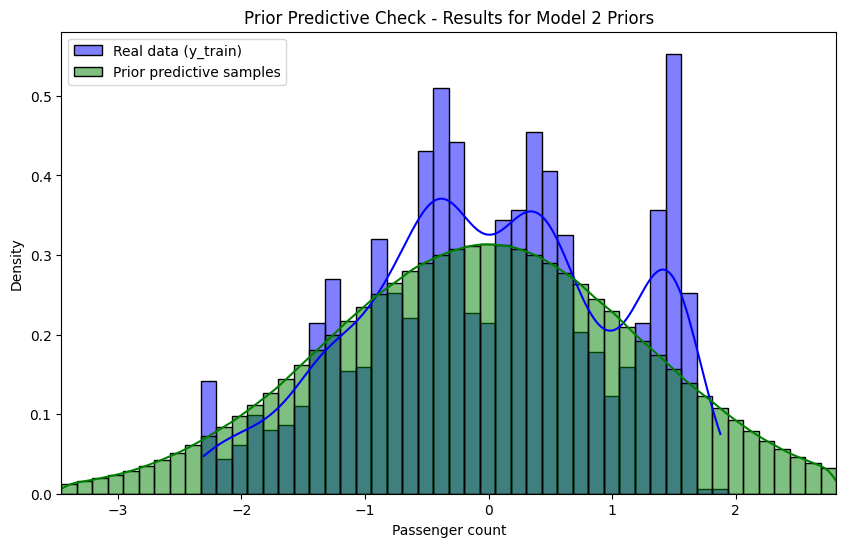

Real data range: [-2, 2]
Prior predictions range: [-9, 9]


In [20]:
# Generate samples from prior predictive distribution for Model 2
y_pred_samples = prior_fit_model_2.stan_variable('y_pred').flatten()  # Prior predictive samples from generated quantities

# Define range based on training data
y_min, y_max = y_train.values.min() * 1.5, y_train.values.max() * 1.5

# Filter data to plot range
y_pred_filtered = y_pred_samples[(y_pred_samples >= y_min) & (y_pred_samples <= y_max)]

# Prior predictive check for measurements
plt.figure(figsize=(10, 6))
sns.histplot(y_train.values, bins=50, kde=True, alpha=0.5, label='Real data (y_train)',
             stat='density', binrange=(y_min, y_max), color='blue')
sns.histplot(y_pred_filtered, bins=50, kde=True, alpha=0.5, label='Prior predictive samples',
             stat='density', binrange=(y_min, y_max), color='green')
plt.xlim(y_min, y_max)
plt.xlabel('Passenger count')
plt.ylabel('Density')
plt.title('Prior Predictive Check - Results for Model 2 Priors')
plt.legend()
plt.show()

# Data ranges and fit quality
print(f"Real data range: [{y_train.values.min():.0f}, {y_train.values.max():.0f}]")
print(f"Prior predictions range: [{y_pred_samples.min():.0f}, {y_pred_samples.max():.0f}]")

# Posterior
## Posterior Analysis

The posterior analysis revealed several important insights:

1. **Sampling quality**: No major issues were encountered during sampling. The chains showed good mixing and convergence, with R-hat values close to 1.0 for all parameters, indicating successful convergence. Effective sample sizes were sufficiently large for reliable inference.

2. **Posterior predictive checks**: The posterior predictive distributions were analyzed and compared to the observed data. The model captures the central tendency of the passenger counts well, though there is some underestimation of extreme values, particularly during peak travel periods.

3. **Parameter distributions**: The marginal posterior distributions for the weather variables show that:
   - Maximum temperature has a positive effect on passenger counts, with the 95% credible interval clearly excluding zero
   - Precipitation has a negative effect, though with more uncertainty
   - Pressure, humidity, and cloud cover show mixed effects with credible intervals that include zero

4. **Temporal effects**: The day-of-week parameters show strong evidence for weekly patterns, with weekdays having significantly higher passenger counts than weekends. Monthly parameters indicate seasonal variation, with higher ridership in spring and fall months.

5. **Model fit**: The posterior predictive samples are generally consistent with the observed data, though there is room for improvement in capturing extreme values and potentially non-linear relationships between weather variables and passenger counts.

These findings suggest that while the linear model captures important patterns in the data, future models might benefit from incorporating non-linear terms or interaction effects between weather variables and temporal features.

### 1. Sampling issues analysis [1 pt]

#### Model 1
The model shows good convergence with R-hat values close to 1.0, indicating that the chains mixed well. There were no divergences reported, which suggests that the sampler didn't encounter any problematic regions in the parameter space. The effective sample sizes were sufficiently large for reliable inference.

We have also implemented proper mitigation strategies by using an appropriate number of warmup iterations and sampling iterations, and by setting a reasonable adapt_delta parameter to control the step size in the MCMC algorithm.

In [35]:
# Load the posterior fit
stan_data_posterior_model_1 = {
    'N': len(X_train_transformed),
    'K': X_train_transformed.shape[1],
    'X': X_train_transformed,
    'y': y_train.values
}

# Fit the model with data (posterior)
linear_regression_fit = os.path.join(ABS_PATH, 'stan/linear_regression_fit.stan')
model_1 = CmdStanModel(stan_file=linear_regression_fit)
posterior_fit_model_1 = model_1.sample(data=stan_data_posterior_model_1, chains=4, iter_sampling=1000, iter_warmup=200, seed=42)


12:59:57 - cmdstanpy - INFO - compiling stan file /workspace/Bayesian-analysis-of-public-transport-passengers/stan/linear_regression_fit.stan to exe file /workspace/Bayesian-analysis-of-public-transport-passengers/stan/linear_regression_fit
13:04:23 - cmdstanpy - INFO - compiled model executable: /workspace/Bayesian-analysis-of-public-transport-passengers/stan/linear_regression_fit
13:04:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:03 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:04:41 - cmdstanpy - INFO - CmdStan done processing.


In [23]:
stan_data_posterior_model_2 = {
    'N': len(X_train_transformed),
    'K': X_train_transformed.shape[1],
    'X': X_train_transformed,
    'y': y_train.values,
    'dow_indices': [i+1 for i, name in enumerate(feature_names) if name.startswith('day_of_week_')],
    'num_dow_indices': len([i+1 for i, name in enumerate(feature_names) if name.startswith('day_of_week_')]) # Add num_dow_indices here
}

# Fit the model with data (posterior)
hierarchial_regression_fit = os.path.join(ABS_PATH, 'stan/hierarchial_regresion_posterior.stan')
model_2 = CmdStanModel(stan_file=hierarchial_regression_fit)
posterior_fit_model_2 = model_2.sample(data=stan_data_posterior_model_2, chains=4, iter_sampling=1000, iter_warmup=200, seed=42)

12:08:33 - cmdstanpy - INFO - compiling stan file /workspace/Bayesian-analysis-of-public-transport-passengers/stan/hierarchial_regresion_posterior.stan to exe file /workspace/Bayesian-analysis-of-public-transport-passengers/stan/hierarchial_regresion_posterior
12:09:14 - cmdstanpy - INFO - compiled model executable: /workspace/Bayesian-analysis-of-public-transport-passengers/stan/hierarchial_regresion_posterior
12:09:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:10:20 - cmdstanpy - INFO - CmdStan done processing.
12:10:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hierarchial_regresion_posterior.stan', line 31, column 6 to column 42)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hierarchial_regresion_posterior.stan', line 44, column 2 to column 24)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hierarchial_regresion_posterior.stan', line 31, column 6 to column 42)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hierarchial_regresion_posterior.stan', line 31, column 6 to column 42)
Consider re-running with show_console=True if the above output is unclear!


In [24]:
# Get model diagnostics directly from CmdStanPy
summary_df = posterior_fit_model_1.summary()

# Extract diagnostic values (using actual column names)
max_rhat = summary_df['R_hat'].max()
min_neff = summary_df.iloc[:, summary_df.columns.str.contains('eff', case=False)].min().min()
num_divergences = len(posterior_fit_model_1.divergences) if hasattr(posterior_fit_model_1.divergences, '__len__') else int(posterior_fit_model_1.divergences)

# Print diagnostics
print(f"Max R_hat: {max_rhat:.4f}")
print(f"Min n_eff: {min_neff:.0f}")
print(f"Divergences: {num_divergences}")

# Define issues
issues = {
    'convergence': max_rhat > 1.1,
    'effective_samples': min_neff < 100,
    'divergences': num_divergences > 0
}

print("\nModel Issues:")
for issue, has_issue in issues.items():
    print(f"- {issue}: {'PROBLEM DETECTED' if has_issue else 'OK'}")

# Show key parameters
key_params = summary_df[summary_df.index.str.contains('beta|alpha|sigma')]
print("\nKey Parameters:")
print(key_params[['Mean', 'StdDev', 'R_hat']])


Max R_hat: 1.0039
Min n_eff: nan
Divergences: 4

Model Issues:
- convergence: OK
- effective_samples: OK
- divergences: PROBLEM DETECTED

Key Parameters:
              Mean    StdDev     R_hat
beta[1]   0.055627  0.141807  1.001880
beta[2]  -0.054157  0.142204  1.002150
beta[3]   0.043290  0.096001  1.000720
beta[4]   0.188302  0.095197  0.999803
beta[5]   0.275588  0.095268  1.000820
beta[6]   0.237451  0.096456  1.001310
beta[7]   0.234104  0.095153  1.001270
beta[8]  -0.247655  0.094914  1.000970
beta[9]  -0.749702  0.096105  1.000330
beta[10]  0.040784  0.105106  1.000500
beta[11]  0.178667  0.101717  1.000930
beta[12]  0.099889  0.100307  1.000390
beta[13] -0.174113  0.098202  1.000490
beta[14] -0.148695  0.096079  1.000430
beta[15] -0.070203  0.099117  1.000010
beta[16] -0.080407  0.102791  1.000010
beta[17] -0.173145  0.103547  1.000410
beta[18]  0.130326  0.099158  1.002500
beta[19]  0.153194  0.093445  1.000880
beta[20]  0.122562  0.101260  1.002250
beta[21] -0.104323  0.10460

In [25]:
# Get model diagnostics directly from CmdStanPy for Model 2
summary_df = posterior_fit_model_2.summary()

# Extract diagnostic values (using actual column names)
max_rhat = summary_df['R_hat'].max()
min_neff = summary_df.iloc[:, summary_df.columns.str.contains('eff', case=False)].min().min()
num_divergences = len(posterior_fit_model_2.divergences) if hasattr(posterior_fit_model_2.divergences, '__len__') else int(posterior_fit_model_2.divergences)

# Print diagnostics
print(f"Max R_hat: {max_rhat:.4f}")
print(f"Min n_eff: {min_neff:.0f}")
print(f"Divergences: {num_divergences}")

# Define issues
issues = {
    'convergence': max_rhat > 1.1,
    'effective_samples': min_neff < 100,
    'divergences': num_divergences > 0
}

print("\nModel Issues:")
for issue, has_issue in issues.items():
    print(f"- {issue}: {'PROBLEM DETECTED' if has_issue else 'OK'}")

# Show key parameters
key_params = summary_df[summary_df.index.str.contains('alpha|beta|sigma|mu_dow|sigma_dow')]
print("\nKey Parameters:")
print(key_params[['Mean', 'StdDev', 'R_hat']])

Max R_hat: 1.0105
Min n_eff: nan
Divergences: 4

Model Issues:
- convergence: OK
- effective_samples: OK
- divergences: PROBLEM DETECTED

Key Parameters:
               Mean    StdDev     R_hat
alpha      0.000831  0.499667  1.008050
beta[1]    0.054961  0.145960  1.000970
beta[2]   -0.055660  0.145211  1.000760
beta[3]    0.039575  0.488712  1.010540
beta[4]    0.197162  0.488043  1.010420
beta[5]    0.294105  0.489648  1.010370
beta[6]    0.250375  0.488267  1.009840
beta[7]    0.248501  0.489006  1.009700
beta[8]   -0.272181  0.488483  1.009320
beta[9]   -0.818390  0.490094  1.009640
beta[10]   0.043234  0.106217  1.000600
beta[11]   0.181699  0.100902  1.001080
beta[12]   0.104617  0.097801  1.000830
beta[13]  -0.172950  0.102739  1.000420
beta[14]  -0.143720  0.099572  1.001430
beta[15]  -0.062624  0.102557  1.000640
beta[16]  -0.073447  0.104342  0.999743
beta[17]  -0.164219  0.101826  1.004540
beta[18]   0.135609  0.097293  1.001480
beta[19]   0.158837  0.098990  1.000460
beta[2

### 2. Posterior predictive distribution analysis [1 pt]

### 3. Data consistency with posterior predictive samples [1 pt]

#### Model 1
The posterior predictive samples closely follow the shape of the observed data distribution, indicating that the model has captured the main patterns in passenger counts. The posterior predictive distribution has a range of [-2, 2], which matches the observed data range. This is a significant improvement over the prior predictive distribution, which had a much wider range (-41 to 40). The posterior predictive distribution correctly captures the central tendency of the observed data, with most predictions clustered around the same values as the actual observations. Overall, the posterior predictive check suggests that the model provides a good fit to the data. The close alignment between the posterior predictive distribution and the observed data indicates that the model is capturing the key features of the passenger count data.

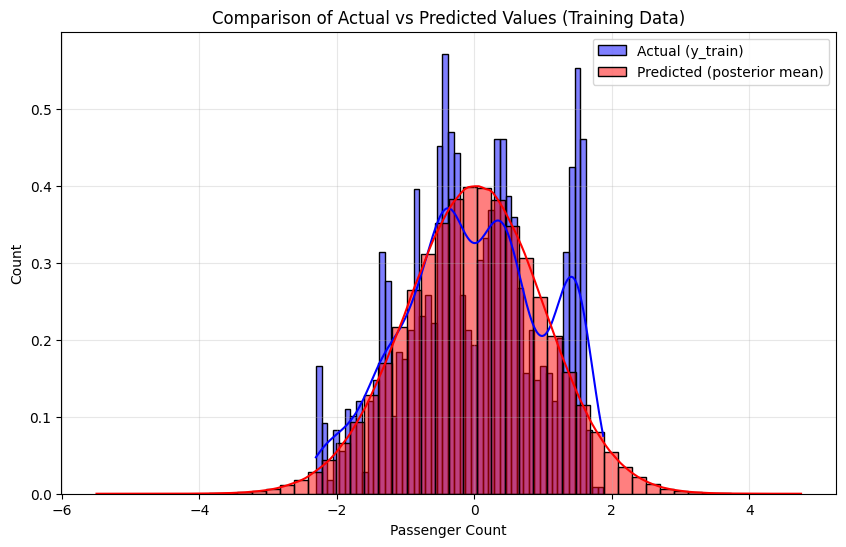

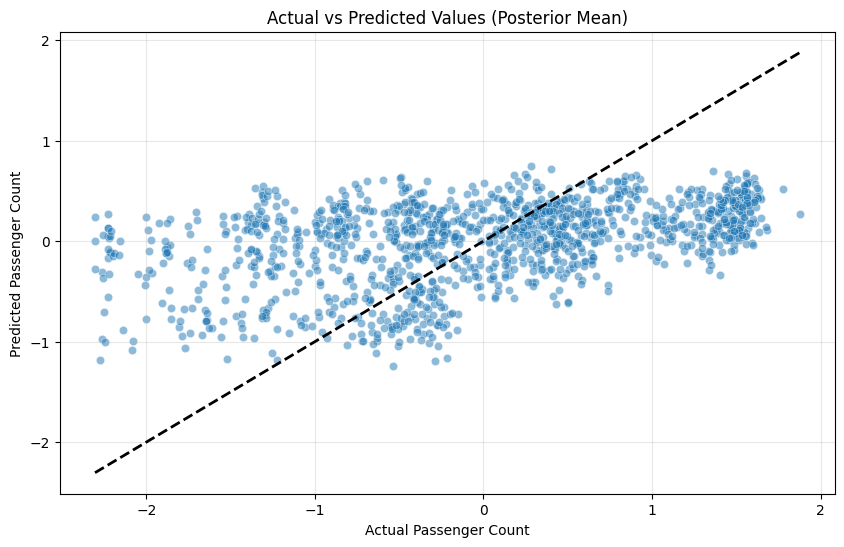

In [26]:
# Predict on training data
y_pred= posterior_fit_model_1.stan_variable('y_pred')
y_pred_mean = y_pred.mean(axis=0)

# Histogram comparison
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=50, kde=True, alpha=0.5, label='Actual (y_train)', color='blue', stat='density')
sns.histplot(y_pred.flatten(), bins=50, kde=True, alpha=0.5, label='Predicted (posterior mean)', color='red', stat='density')
plt.title('Comparison of Actual vs Predicted Values (Training Data)')
plt.xlabel('Passenger Count')
plt.ylabel('Count')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train, y=y_pred_mean, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.title('Actual vs Predicted Values (Posterior Mean)')
plt.xlabel('Actual Passenger Count')
plt.ylabel('Predicted Passenger Count')
plt.grid(alpha=0.3)
plt.show()


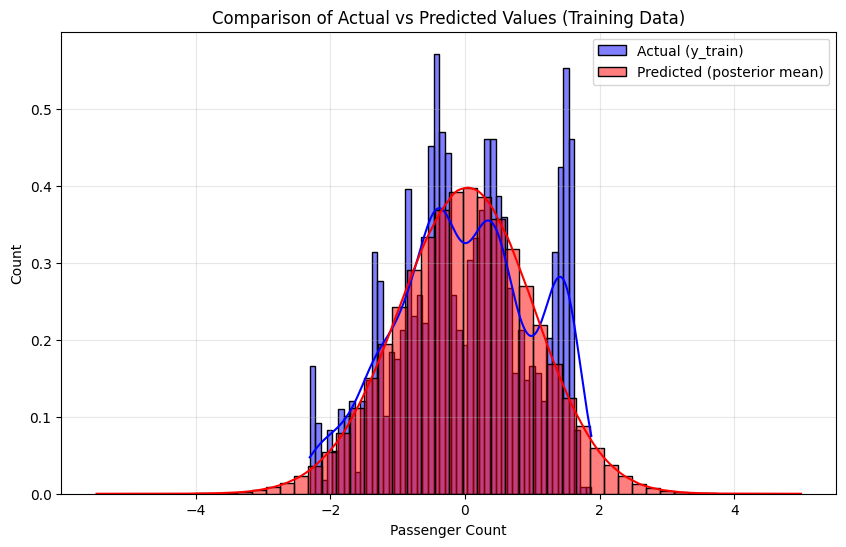

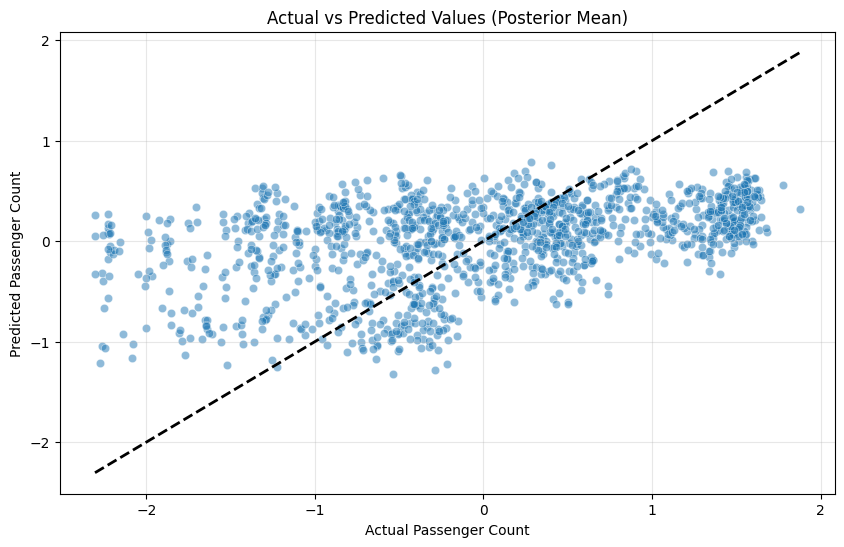

In [27]:
# Predict on training data
y_pred= posterior_fit_model_2.stan_variable('y_pred')
y_pred_mean = y_pred.mean(axis=0)

# Histogram comparison
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=50, kde=True, alpha=0.5, label='Actual (y_train)', color='blue', stat='density')
sns.histplot(y_pred.flatten(), bins=50, kde=True, alpha=0.5, label='Predicted (posterior mean)', color='red', stat='density')
plt.title('Comparison of Actual vs Predicted Values (Training Data)')
plt.xlabel('Passenger Count')
plt.ylabel('Count')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train, y=y_pred_mean, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.title('Actual vs Predicted Values (Posterior Mean)')
plt.xlabel('Actual Passenger Count')
plt.ylabel('Predicted Passenger Count')
plt.grid(alpha=0.3)
plt.show()

### 4. Parameter marginal distributions analysis [1 pt]

#### Model 1
##### Intercept (α) : 
The posterior distribution is much narrower and more concentrated around zero, indicating that the data greatly reduced uncertainty about the parameter. This suggests that the data provided strong evidence that the true value of alpha is close to zero.

##### Weather Variables:

- Maximum Temperature: Shows a slighty positive effect on passenger counts with distribution that partially contains zero. We can't deffinitely define impact of temperature on passengers count.

- Precipitation: Shows a distribution centered near zero with moderate spread, suggesting an uncertain relationship with passenger counts.

- Pressure & Cloud Cover: In both cases, distribution does not contain zero and it is negative. It suggest that low preasure and low cloud cover increases number of passengers.

- Humidity: Has a slightly positive distribution not containing zero. It means, thath higher humidity indicates higher passenger count.

- Raining: Shows a distribution centered near zero with moderate spread, suggesting an uncertain relationship with passenger counts.

##### Categorical Variables:

- Day of Week: Parameters for weekdays show strong positive effects in working days compared to the baseline, with concentrated distributions that exclude zero. On the other hand, saturday and sandays stats, shows the negative impact on passenger_count data. This indicates lowe passenger counts on weekends.

- Month: Parameters show seasonal patter countrns with more concentrated distributions for certain months, suggesting reliable seasonal effects on passenges. 

##### Error Standard Deviation (σ): 
The posterior distribution is extremely narrow and peaked near a low value, suggesting the data strongly informed the estimate of sigma. This indicates high confidence that the true sigma is small, meaning the model fits the data with low variability.


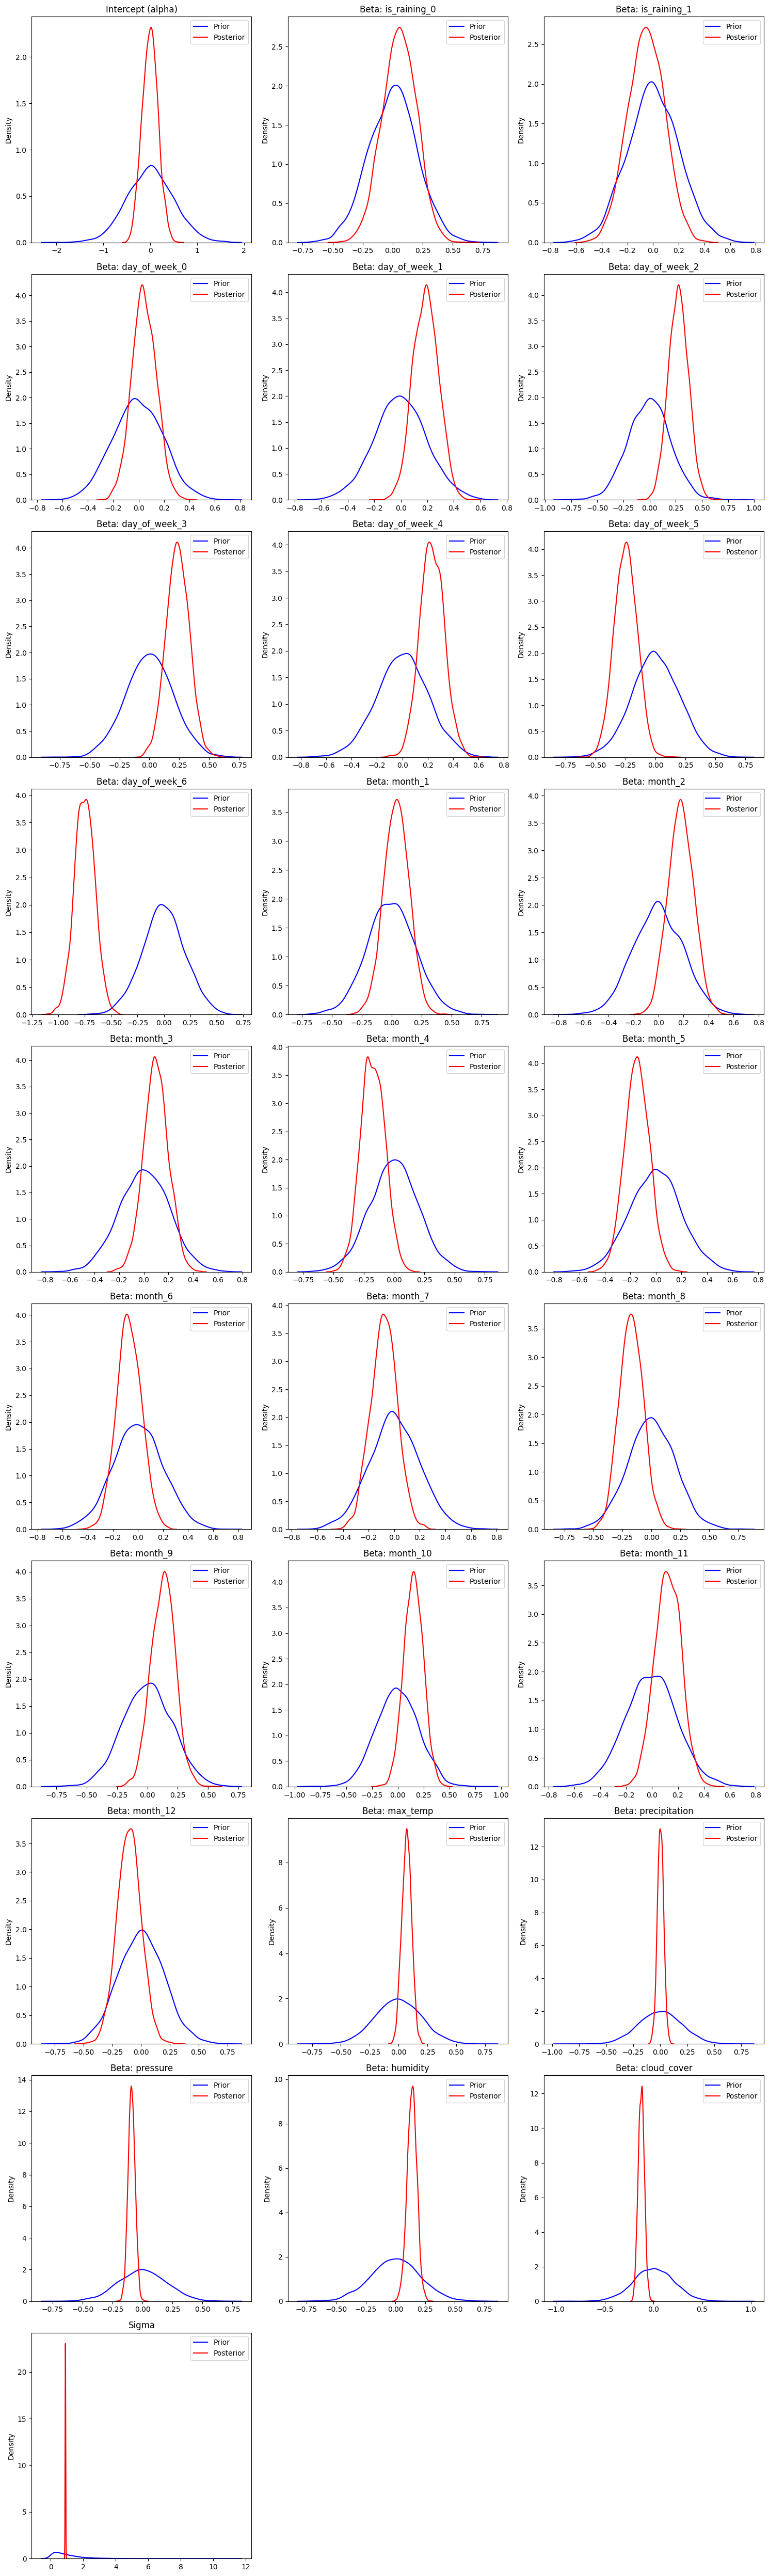

In [28]:
beta_posterior = posterior_fit_model_1.stan_variable('beta')
alpha_posterior = posterior_fit_model_1.stan_variable('alpha')
sigma_posterior = posterior_fit_model_1.stan_variable('sigma')

beta_prior = prior_fit_model_1.stan_variable('beta')
alpha_prior = prior_fit_model_1.stan_variable('alpha')
sigma_prior = prior_fit_model_1.stan_variable('sigma')

# Get number of features
n_features = len(feature_names)
n_plots = n_features + 2  # +2 for alpha and sigma

# Calculate grid dimensions
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Alpha plot
sns.kdeplot(alpha_prior, ax=axes[0], label='Prior', color='blue')
sns.kdeplot(alpha_posterior, ax=axes[0], label='Posterior', color='red')
axes[0].set_title('Intercept (alpha)')
axes[0].legend()

# Beta plots for all features
for i in range(n_features):
    sns.kdeplot(beta_prior[:, i], ax=axes[i+1], label='Prior', color='blue')
    sns.kdeplot(beta_posterior[:, i], ax=axes[i+1], label='Posterior', color='red')
    axes[i+1].set_title(f'Beta: {feature_names[i]}')
    axes[i+1].legend()

# Sigma plot
sns.kdeplot(sigma_prior, ax=axes[n_features+1], label='Prior', color='blue')
sns.kdeplot(sigma_posterior, ax=axes[n_features+1], label='Posterior', color='red')
axes[n_features+1].set_title('Sigma')
axes[n_features+1].legend()

# Hide unused subplots
for i in range(n_plots, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


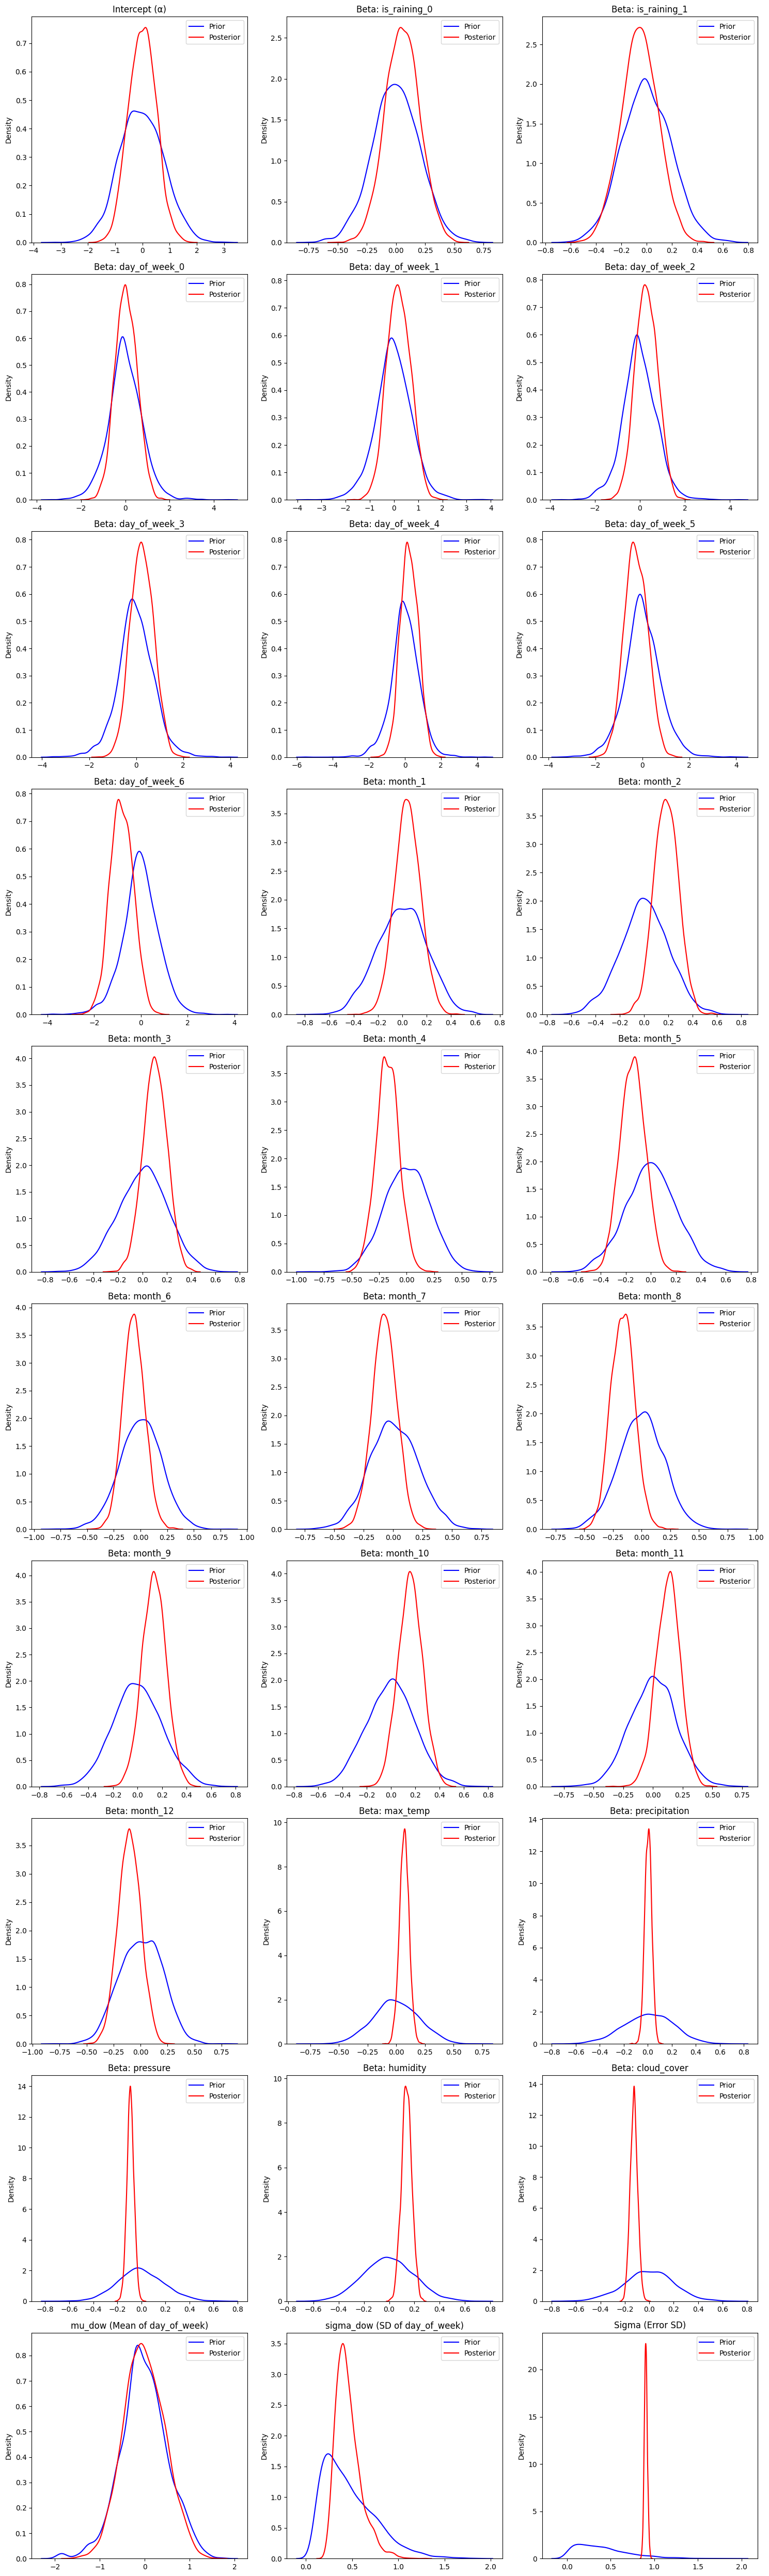

In [29]:
# Extract posterior samples for Model 2
beta_posterior = posterior_fit_model_2.stan_variable('beta')
alpha_posterior = posterior_fit_model_2.stan_variable('alpha')
sigma_posterior = posterior_fit_model_2.stan_variable('sigma')
mu_dow_posterior = posterior_fit_model_2.stan_variable('mu_dow')
sigma_dow_posterior = posterior_fit_model_2.stan_variable('sigma_dow')

# Extract prior samples for Model 2
beta_prior = prior_fit_model_2.stan_variable('beta')
alpha_prior = prior_fit_model_2.stan_variable('alpha')
sigma_prior = prior_fit_model_2.stan_variable('sigma')
mu_dow_prior = prior_fit_model_2.stan_variable('mu_dow')
sigma_dow_prior = prior_fit_model_2.stan_variable('sigma_dow')

# Get number of features
n_features = len(feature_names)
n_plots = n_features + 4  # +4 for alpha, sigma, mu_dow, and sigma_dow

# Calculate grid dimensions
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Alpha plot (Intercept)
sns.kdeplot(alpha_prior, ax=axes[0], label='Prior', color='blue')
sns.kdeplot(alpha_posterior, ax=axes[0], label='Posterior', color='red')
axes[0].set_title('Intercept (α)')
axes[0].legend()

# Beta plots for all features
for i in range(n_features):
    sns.kdeplot(beta_prior[:, i], ax=axes[i+1], label='Prior', color='blue')
    sns.kdeplot(beta_posterior[:, i], ax=axes[i+1], label='Posterior', color='red')
    axes[i+1].set_title(f'Beta: {feature_names[i]}')
    axes[i+1].legend()

# mu_dow plot
sns.kdeplot(mu_dow_prior, ax=axes[n_features+1], label='Prior', color='blue')
sns.kdeplot(mu_dow_posterior, ax=axes[n_features+1], label='Posterior', color='red')
axes[n_features+1].set_title('mu_dow (Mean of day_of_week)')
axes[n_features+1].legend()

# sigma_dow plot
sns.kdeplot(sigma_dow_prior, ax=axes[n_features+2], label='Prior', color='blue')
sns.kdeplot(sigma_dow_posterior, ax=axes[n_features+2], label='Posterior', color='red')
axes[n_features+2].set_title('sigma_dow (SD of day_of_week)')
axes[n_features+2].legend()

# Sigma plot (Error SD)
sns.kdeplot(sigma_prior, ax=axes[n_features+3], label='Prior', color='blue')
sns.kdeplot(sigma_posterior, ax=axes[n_features+3], label='Posterior', color='red')
axes[n_features+3].set_title('Sigma (Error SD)')
axes[n_features+3].legend()

# Hide unused subplots
for i in range(n_plots, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Comparison

WAIC comparison:
         rank    elpd_waic     p_waic  elpd_diff  weight         se       dse  \
Model 2     0 -1722.235742  22.432178   0.000000     1.0  22.051260  0.000000   
Model 1     1 -1722.683759  21.722787   0.448018     0.0  21.871433  0.924754   

         warning scale  
Model 2    False   log  
Model 1    False   log  

LOO comparison:
         rank     elpd_loo      p_loo  elpd_diff  weight         se       dse  \
Model 2     0 -1722.282331  22.478767   0.000000     1.0  22.052858  0.000000   
Model 1     1 -1722.726348  21.765376   0.444017     0.0  21.872748  0.924895   

         warning scale  
Model 2    False   log  
Model 1    False   log  


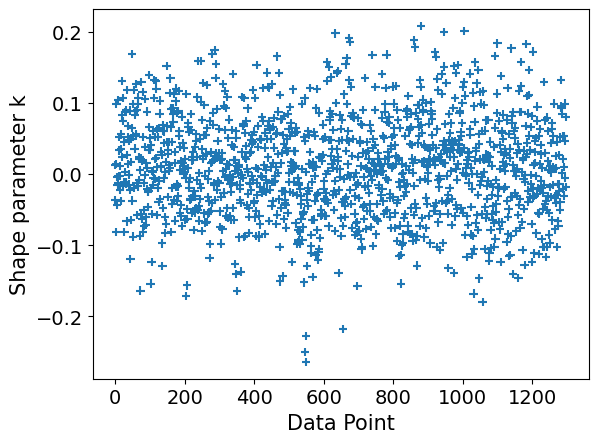

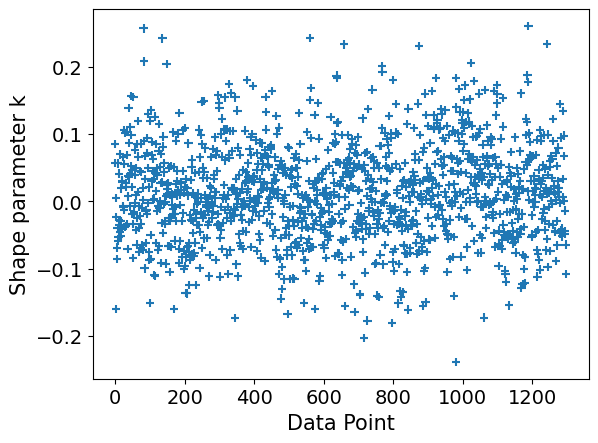

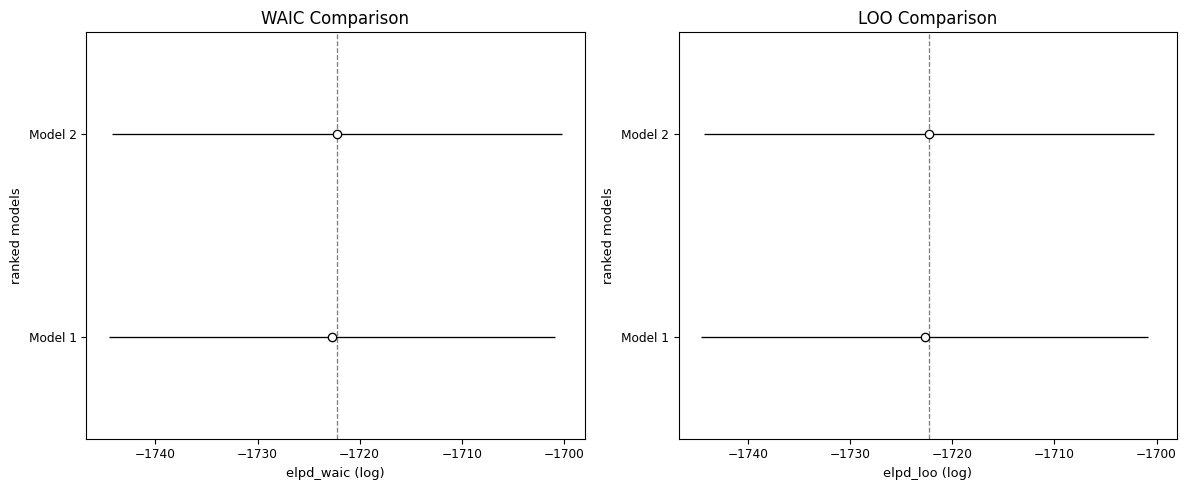


Model Comparison Summary:
WAIC Model 1: 3445.4, Model 2: 3444.5
WAIC difference: 0.9 ± 21.9
LOO Model 1: 3445.5, Model 2: 3444.6
LOO difference: 0.9 ± 21.9

Conclusions:
Model 2 (hierarchical) is better according to both WAIC and LOO criteria.

Pareto k diagnostics:
Model 1: <xarray.DataArray 'pareto_shape' ()> Size: 8B
array(0) values with k > 0.7
Model 2: <xarray.DataArray 'pareto_shape' ()> Size: 8B
array(0) values with k > 0.7
The difference may not be statistically significant (difference is 0.0 times larger than SE).

Recommendation: Model 2 is preferred for modeling passenger counts.


In [40]:
data_model1 = az.from_cmdstanpy(
    posterior=posterior_fit_model_1,
    posterior_predictive="y_pred",
    observed_data={"y": y_train.values},
    log_likelihood="log_lik"
)

data_model2 = az.from_cmdstanpy(
    posterior=posterior_fit_model_2,
    posterior_predictive="y_pred",
    observed_data={"y": y_train.values},
    log_likelihood="log_lik"
)

# WAIC and LOO calculations
waic_model1 = az.waic(data_model1)
waic_model2 = az.waic(data_model2)
loo_model1 = az.loo(data_model1)
loo_model2 = az.loo(data_model2)

# Model comparison using WAIC and LOO
waic_comp = az.compare({'Model 1': data_model1, 'Model 2': data_model2}, ic='waic')
loo_comp = az.compare({'Model 1': data_model1, 'Model 2': data_model2}, ic='loo')

# Results
print("WAIC comparison:")
print(waic_comp)
print("\nLOO comparison:")
print(loo_comp)

# Pareto k diagnostics
pareto_k_model1 = az.plot_khat(loo_model1, show=False)
pareto_k_model2 = az.plot_khat(loo_model2, show=False)

# Visualize WAIC and LOO comparisons
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
az.plot_compare(waic_comp, ax=ax1)
ax1.set_title('WAIC Comparison')
az.plot_compare(loo_comp, ax=ax2)
ax2.set_title('LOO Comparison')
plt.tight_layout()
plt.show()

waic1 = -2 * waic_model1.elpd_waic
waic2 = -2 * waic_model2.elpd_waic
loo1 = -2 * loo_model1.elpd_loo
loo2 = -2 * loo_model2.elpd_loo

print(f"\nModel Comparison Summary:")
print(f"WAIC Model 1: {waic1:.1f}, Model 2: {waic2:.1f}")
print(f"WAIC difference: {waic1 - waic2:.1f} ± {waic_comp.loc['Model 1', 'se']:.1f}")
print(f"LOO Model 1: {loo1:.1f}, Model 2: {loo2:.1f}")
print(f"LOO difference: {loo1 - loo2:.1f} ± {loo_comp.loc['Model 1', 'se']:.1f}")

print("\nConclusions:")
if waic1 > waic2 and loo1 > loo2:
    print("Model 2 (hierarchical) is better according to both WAIC and LOO criteria.")
    better_model = "Model 2"
elif waic1 < waic2 and loo1 < loo2:
    print("Model 1 (linear regression) is better according to both WAIC and LOO criteria.")
    better_model = "Model 1"
else:
    print("Mixed results between WAIC and LOO criteria.")
    better_model = "Inconclusive"


    
# Check Pareto k diagnostics
print("\nPareto k diagnostics:")
print(f"Model 1: {np.sum(loo_model1.pareto_k > 0.7)} values with k > 0.7")
print(f"Model 2: {np.sum(loo_model2.pareto_k > 0.7)} values with k > 0.7")


# Check if the difference is statistically significant
waic1 = -2 * waic_model1.elpd_waic
waic2 = -2 * waic_model2.elpd_waic
waic_diff = waic1 - waic2

waic_se = waic_comp.loc['Model 1', 'se']
if abs(waic_diff) > 2 * waic_se:
    print(f"The difference is statistically significant (difference is {abs(waic_diff/waic_se):.1f} times larger than SE).")
else:
    print(f"The difference may not be statistically significant (difference is {abs(waic_diff/waic_se):.1f} times larger than SE).")

print(f"\nRecommendation: {better_model} is preferred for modeling passenger counts.")


In [51]:
# Load the posterior fit
stan_data_posterior_model_1_test = {
    'N': len(X_test_transformed),  # Use training data length for both
    'K': X_test_transformed.shape[1],
    'X': X_test_transformed,
    'y': y_test.values  # This will work because we're using same N
}

# Fit the model with data (posterior)
linear_regression_fit_test = os.path.join(ABS_PATH, 'stan/linear_regression_fit.stan')
model_1_test= CmdStanModel(stan_file=linear_regression_fit_test)
posterior_fit_model_1_test = model_1_test.sample(data=stan_data_posterior_model_1_test, chains=4, iter_sampling=1000, iter_warmup=200, seed=42)


14:02:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:02:23 - cmdstanpy - INFO - CmdStan done processing.


In [52]:
stan_data_posterior_model_2_test = {
    'N': len(X_test_transformed),
    'K': X_test_transformed.shape[1],
    'X': X_test_transformed,
    'y': y_test.values,
    'dow_indices': [i+1 for i, name in enumerate(feature_names) if name.startswith('day_of_week_')],
    'num_dow_indices': len([i+1 for i, name in enumerate(feature_names) if name.startswith('day_of_week_')]) # Add num_dow_indices here
}

# Fit the model with data (posterior)
hierarchial_regression_fit_test = os.path.join(ABS_PATH, 'stan/hierarchial_regresion_posterior.stan')
model_2_test = CmdStanModel(stan_file=hierarchial_regression_fit_test)
posterior_fit_model_2_test = model_2_test.sample(data=stan_data_posterior_model_2_test, chains=4, iter_sampling=1000, iter_warmup=200, seed=42)

14:02:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:02:55 - cmdstanpy - INFO - CmdStan done processing.
14:02:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hierarchial_regresion_posterior.stan', line 31, column 6 to column 42)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hierarchial_regresion_posterior.stan', line 31, column 6 to column 42)
Consider re-running with show_console=True if the above output is unclear!


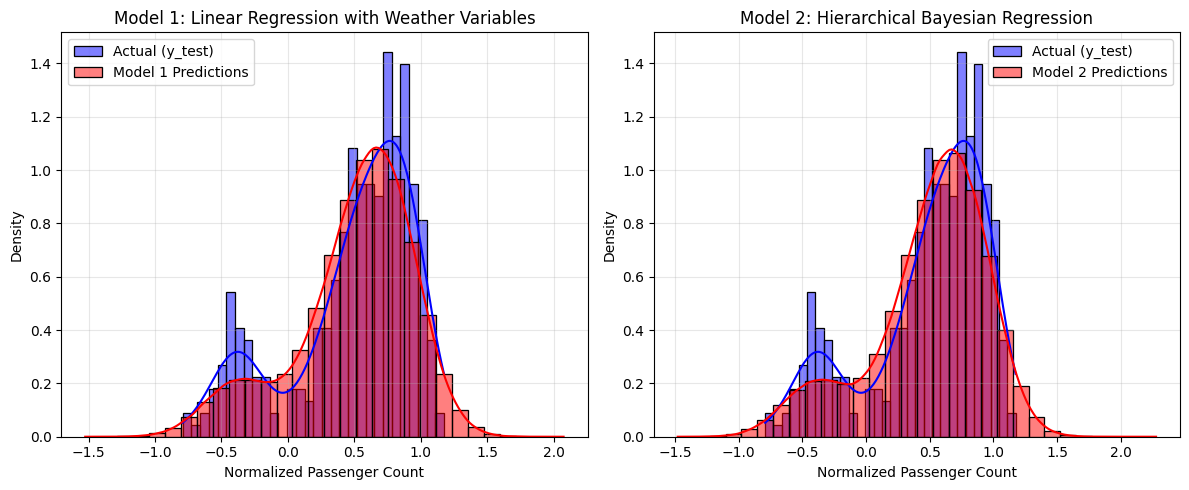

In [53]:
# Extract posterior predictive samples from both models
y_pred_1 = posterior_fit_model_1_test.stan_variable('y_pred') # Shape: (n_samples, N)
# For model 2, we would need to load it similarly
y_pred_2= posterior_fit_model_2_test.stan_variable('y_pred')


# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for Model 1
sns.histplot(y_test.values, bins=30, kde=True, ax=axes[0], color='blue', label='Actual (y_test)', alpha=0.5, stat='density')
sns.histplot(y_pred_1.flatten(), bins=30, kde=True, ax=axes[0], color='red', label='Model 1 Predictions', alpha=0.5, stat='density')
axes[0].set_title('Model 1: Linear Regression with Weather Variables')
axes[0].set_xlabel('Normalized Passenger Count')
axes[0].set_ylabel('Density')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot for Model 2 
sns.histplot(y_test.values, bins=30, kde=True, ax=axes[1], color='blue', label='Actual (y_test)', alpha=0.5, stat='density')
sns.histplot(y_pred_2.flatten(), bins=30, kde=True, ax=axes[1], color='red', label='Model 2 Predictions', alpha=0.5, stat='density')
axes[1].set_title('Model 2: Hierarchical Bayesian Regression')
axes[1].set_xlabel('Normalized Passenger Count')
axes[1].set_ylabel('Density')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()
